# Topic: Real-time Anomaly Detection in Financial Transactions
        


## Authors and Team
- **Team Name**: Buckeyes
- **Author 1**: Zhoujun Cao
- **Author 2**: Allen Zhang


        


## Abstract

This project builds a decision-focused, real-time fraud control system on the IEEE-CIS dataset, linking descriptive → predictive → prescriptive analytics in a closed loop. We profile 590k transactions (434 post-merge features), handle severe missingness (drop >40%-missing columns; median/mode imputation with missingness indicators), and stabilize heavy-tailed numerics via a Modified Z-Score screen with log/cap transforms; high-variance signals are standardized and optionally compressed via PCA. Class imbalance (~3.5% fraud) is addressed with class weights and balanced samples for iteration.
For modelling, we adopt **LightGBM** as the primary baseline—selected over Isolation Forest, Autoencoders, and Logistic Regression—and plan head-to-head comparisons with XGBoost and CatBoost. Evaluation emphasizes ROC-AUC, Matthew’s Correlation Coefficient (MCC), operational error rates (e.g., FPR at policy thresholds), approval/chargeback rates, and latency (target p95 ≤ 300 ms, model p95 ≤ 100 ms).We expect a deployable prototype that improves decision value at **low FPR**, reduces manual review, and delivers measurable cost savings with **reproducible artefacts**.
        

## Project Description

### 1.Introduction

#### 1.1 What is the Research Problem that you will be addressing using an Analytical Framework?

We face a **closed-loop decision** problem, not just a prediction task: score each incoming transaction and select the optimal action (**Allow / Step-Up / Manual Review / Block**) to **minimize expected cost** under latency, capacity, and governance constraints. In our pipeline, **descriptive** analytics profiles the data and leakage, **predictive** analytics produces calibrated risk scores, and **prescriptive** analytics converts scores into actions via an objective and constraints. Techniques we plan to evaluate include **Isolation Forest** and **Autoencoder**–style anomaly detectors for unknown patterns [1][2], **GBDT** family models (LightGBM / CatBoost / XGBoost) for supervised baselines [3][4][5], and **sequence models (RNN/LSTM)** to capture short-term behavioral dynamics [6]. The **IEEE-CIS Fraud Detection** dataset provides large-scale, time-ordered transactions for offline training and stream replay [8]; a **hybrid** approach that blends supervised and unsupervised/sequence components is supported by recent practice [7].

To satisfy the rubric’s “gap with measures,” we set concrete targets: **≥30%** reduction in fraud loss per 1,000 transactions, **≥20%** lift in recall at **FPR ≤ 1.0%**, **p95 latency ≤ 300 ms** (model p95 ≤ 100 ms), and **−15%** manual-review rate with stable approvals. These are explicit measures tied to decision value and will be evaluated on **time-ordered** splits and **stream replay** using [8].



#### 1.2 Motivation

**Scale & drift.** Transaction volumes are high and attacker behavior evolves, so rule-only or stale batch models degrade. Unsupervised/autoencoding methods can surface **novel** anomalies [1][2], while LSTM-style sequence learners model **temporal context** (bursts, device/account histories) [6].  

**Decision-centric value.** Tree-boosting baselines are strong, fast, and interpretable enough for feature importance and reason codes [3][4][5], but **decision quality** ultimately depends on calibrated probabilities and **cost-aware** thresholds that minimize expected loss—hence the prescriptive layer.

**Learning opportunity.** The project touches **class imbalance**, **calibration**, **streaming features**, **latency engineering**, and **governance/explainability**, and it leverages a realistic, well-documented dataset [8] with space to test **hybrid** model stacks [7].



#### 1.3 What decisions will you be impacting?

We impact the **transaction-time routing** decision using a calibrated risk score and a policy under SLAs and capacity.

**Actions & typical triggers**
- **Allow:** low risk; consistent device/account; no velocity or geo anomalies.
- **Step-Up (OTP / 3-DS):** medium risk; low-friction verification is justified.
- **Manual Review:** near boundary; high ticket size; conflicting signals.
- **Block:** very high risk; strong rule violations (e.g., blacklisted device, impossible geo-hop).

**Policies to compare**
1) Single-threshold blocking;  
2) Score-band triage (allow / step-up / review / block);  
3) **Cost-based** thresholds using $(L, C_{\text{FP}}, C_{\text{SU}}, C_{\text{RV}})$;  
4) **Rules + model** cascade for obvious vs. gray-zone cases.

**Operational knobs**
Segment-specific thresholds (channel, ticket size), dynamic throttling when review queues spike, and latency-aware fallbacks (lighter model at peak load).



#### 1.4 What is the business/societal value of the decisions to be impacted?

**Business value (reported as net savings per 1,000 transactions):**
$$
\text{Net Savings}
=(\mathrm{TP}\cdot L)
-(\mathrm{FP}\cdot C_{\mathrm{FP}})
-(\mathrm{SU}\cdot C_{\mathrm{SU}})
-(\mathrm{RV}\cdot C_{\mathrm{RV}}).
$$

Alongside this cost metric, we will report **approval rate**, **chargeback rate**, **p95 latency**, and **AUC-PR / Recall@FPR** to pair technical performance with operational and economic outcomes. Our model choices (IForest/Autoencoder/GBDT/RNN) reflect complementary strengths for **unknown-pattern detection**, **feature-rich supervised learning**, and **temporal dynamics** [1].

**Societal value.** Fewer successful frauds reduce identity-theft harms and strengthen trust; fewer wrongful declines improve fairness and access for legitimate customers.

**Academic value.** Demonstrates the full **descriptive → predictive → prescriptive** arc on a high-stakes domain, including **calibration**, **cost-sensitive evaluation**, and **policy design**—with reproducible experiments on a public benchmark [8].


#### 1.5 Why is this project important to you?

It is a hands-on exercise in **decision-focused analytics**: engineering a governed **decision system** that links predictions to actions and outcomes under real constraints (latency, fairness, capacity). It is technically engaging (sequence/anomaly models, boosting, streaming features, low-latency serving) and socially meaningful (protecting users and institutions) 

#### 1.6 Data Assets

Our study is based on the IEEE-CIS Fraud Detection Dataset (Kaggle, 2019), designed to benchmark models for online payment fraud detection. The dataset simulates a real-world financial environment where the main goal is to identify whether each transaction is fraudulent. It includes a training set of approximately 590,000 records (with around 3.5% labeled as fraud) and a test set of about 500,000 transactions, capturing the naturally imbalanced distribution of fraud events observed in financial systems.

These assets provide a comprehensive view of transactional behavior, integrating card, address, device, and anonymized behavioral signals. The diversity and granularity of features—spanning numeric, categorical, and engineered aggregates—enable the exploration of behavioral, geographic, and digital identity patterns that are predictive of fraudulent activity.

From a business standpoint, the dataset reflects the operational challenges faced by financial institutions, where fraud incurs direct financial loss and erodes user trust. Building effective models on such data contributes to risk scoring, anomaly detection, and fraud prevention systems, which can significantly improve decision automation and reduce false positives.

In terms of availability and usability, the dataset is publicly accessible, well-documented, and widely used in both academia and industry. Its large scale, high dimensionality, and partially missing information offer a realistic environment to evaluate data preprocessing, feature engineering, and model generalization strategies under practical constraints.



### 2. Data and Data Preprocessing

#### 2.1 Data Description

We analyze the IEEE-CIS Fraud Detection Dataset, which consists of two joined tables:
- Transaction table: **590,540 rows × 394 columns** covering card, address, device, and engineered V-series aggregates; each row is a unique purchase attempt.
- Identity table: **144,233 rows × 41 columns** capturing device/browser fingerprints, IP traits, and anonymised digital identity metadata for a subset of transactions.
- After joining on `TransactionID`, we analyse **434 features** per record. The feature landscape contains **402 ratio**, **31 nominal**, and **1 interval** variables after automated type inference; these groupings steer our choice of statistics, imputations, and encodings.
- We retain both raw identifiers (e.g., `card1`, `addr1`) and engineered signals (e.g., `C`/`D` counts and V-series anonymised features) so that downstream modelling can experiment with behavioural, geographic, and device-level hypotheses.

Key shape metrics:

| Metric | Value |
| --- | --- |
| Transactions | 590540 |
| Features (post-merge) | 434 |


Representative variables spanning numeric and categorical spaces:

| Feature | Type | Missing (%) |
| --- | --- | --- |
| TransactionID | Ratio | 0.0 |
| isFraud | Ratio | 0.0 |
| TransactionAmt | Ratio | 0.0 |
| card1 | Ratio | 0.0 |
| card4 | Nominal | 0.27 |
| DeviceType | Nominal | 76.16 |


The blend of continuous (`TransactionAmt`), ordinal counts (`card1`), and nominal attributes (`card4`, `DeviceType`) underscores why the cleaning pipeline differentiates scaling, encoding, and imputation strategies by feature class.

#### 2.2 Descriptive Profiling
- **Numeric behaviour**: `TransactionAmt` and distance features are heavily right-skewed, with extremely high kurtosis (>1100). The `C` (count-based) and `D` (timedelta) series display long tails yet hold valuable information about customer velocity. This confirms the need for log transforms and robust statistics (median-based imputations) before modelling.
- **Categorical behaviour**: Payment channels are dominated by a handful of levels—`ProductCD` is concentrated in product "W" while `card4` is primarily "visa" and "mastercard". Device metadata is sparsely populated, but the presence of `desktop` vs `mobile` categories motivates the derived mobility feature.
- **Fraud prevalence**: Only ~3.5% of transactions are marked fraudulent, reaffirming the need for class-imbalance techniques later in the workflow.

Selected numeric statistics (pre-cleaning):

| Feature | Mean | Median | Std | Skewness | Kurtosis | Missing (%) |
| --- | --- | --- | --- | --- | --- | --- |
| TransactionAmt | 135.02717637247264 | 68.769 | 239.16252201373405 | 14.374489573829829 | 1123.9569070220027 | 0.0 |
| dist1 | 118.50218030881064 | 8.0 | 371.8720264911674 | 5.108190015971106 | 36.80227784186971 | 59.65 |
| C1 | 14.092457750533413 | 1.0 | 133.5690179994049 | 23.9579596543205 | 669.380336173549 | 0.0 |
| D1 | 94.34756843625428 | 3.0 | 157.6603865208987 | 1.805381265167042 | 2.198291459914286 | 0.21 |
| V1 | 0.9999453820525424 | 1.0 | 0.0073902056673672 | -135.30031965152918 | 18304.29411462643 | 47.29 |


Key categorical distributions:

| Feature | Unique Count | Missing (%) | Top Categories |
| --- | --- | --- | --- |
| ProductCD | 5 | 0.0 | {'W': 439670, 'C': 68519, 'R': 37699, 'H': 33024, 'S': 11628} |
| card4 | 4 | 0.27 | {'visa': 384767, 'mastercard': 189217, 'american express': 8328, 'discover': 6651, nan: 1577} |
| DeviceType | 2 | 76.16 | {nan: 449730, 'desktop': 85165, 'mobile': 55645} |


Fraud rate snapshot:

| Class | Count | Percentage |
| --- | --- | --- |
| Non-Fraud | 569877 | 96.50099908558268 |
| Fraud | 20663 | 3.4990009144173126 |


Interpretation highlights:
- The steep kurtosis of `TransactionAmt` and `V1` explains why z-score standardisation plus PCA are helpful: models sensitive to variance will otherwise be dominated by a few extreme values.
- `DeviceType` exhibits heavy missingness (76%), suggesting that the missingness indicator itself could carry predictive signal (e.g., absence of a device fingerprint).
- Fraud transactions are significantly rarer, so recall-oriented evaluation and resampling will be critical.

#### 2.3 Missingness & Integrity Checks
- **Missingness profile**: Identity fields suffer from extreme sparsity; the top ten missing columns exceed 89–99% NaNs and are slated for removal under the 40% threshold policy.
- **Imputation readiness**: For features we keep, the missingness percentages in the numeric summary indicate where median or mode replacement will be triggered. The pipeline also introduces `is_<feature>_missing` indicators for every imputed column to preserve behavioural signals.
- **Integrity validation**: Before cleaning we verify essential business rules—positive transaction amounts, monotonically increasing timestamps, and valid card network/type combinations. Only `card6` contains a minor set of anomalous values requiring review.

Worst-missing columns and decisions:

| Feature | Missing (%) | Decision |
| --- | --- | --- |
| id_24 | 99.2 | Drop |
| id_25 | 99.13 | Drop |
| id_26 | 99.13 | Drop |
| id_21 | 99.13 | Drop |
| id_08 | 99.13 | Drop |
| id_07 | 99.13 | Drop |
| id_27 | 99.12 | Drop |
| id_23 | 99.12 | Drop |
| id_22 | 99.12 | Drop |
| dist2 | 93.63 | Drop |


Integrity check summary:

| Check | Status | Affected Rows |
| --- | --- | --- |
| TransactionAmt > 0 | Pass | 0 |
| TransactionDT non-decreasing | Pass | 0 |
| card4 in known networks | Pass | 0 |
| card6 in {credit,debit} | Review | 45 |


These diagnostics justify the specific cleaning steps (column drops, imputation, indicator creation) documented in Section 2.5 and provide concrete figures for the project report.

#### 2.4 Outlier Detection Method
To quantify extreme behaviour we apply the **Modified Z-Score** method (recommended in *Data Quality Analytics*) to heavy-tailed numeric variables such as `TransactionAmt`, `dist1`, `dist2`, `C1`, and `D1`. The statistic is defined as:

$$ M_i = 0.6745 \times \frac{\left| x_i - \operatorname{median}(x) \right|}{\operatorname{MAD}(x)} $$

where $\operatorname{MAD}(x)$ is the median absolute deviation. The scaling constant 0.6745 appears because, for a standard normal distribution, $\operatorname{MAD} \approx 0.6745\sigma$; scaling by 0.6745 makes the modified z-score comparable to a traditional z-score (one unit ≈ one standard deviation). Observations with $M_i > 3.5$ are flagged as outliers. 

The analysis is reproducible via the snippet below:

```python
import numpy as np
import pandas as pd

cols = ['TransactionAmt', 'dist1', 'dist2', 'C1', 'D1']
df = pd.read_csv('Data/train_transaction.csv', usecols=cols)
summary = []
for col in cols:
    series = df[col].dropna()
    mad = (series - series.median()).abs().median()
    modified_z = 0.6745 * (series - series.median()).abs() / mad
    outliers = (modified_z > 3.5).sum() if mad else 0
    summary.append({'Feature': col, 'Median': series.median(),
                    'MAD': mad, 'Outliers (>3.5)': outliers,
                    'Outlier %': outliers / len(series) * 100})
outlier_summary = pd.DataFrame(summary)
```

Detected outliers (pre-cleaning):

| Feature | Median | MAD | Outliers (>3.5) | Outlier % |
| --- | --- | --- | --- | --- |
| TransactionAmt | 68.769 | 38.8 | 59443 | 10.066 |
| dist1 | 8.0 | 7.0 | 43747 | 18.36 |
| dist2 | 37.0 | 37.0 | 8689 | 23.092 |
| C1 | 1.0 | 0.0 | 0 | 0.0 |
| D1 | 3.0 | 3.0 | 254204 | 43.139 |


Key takeaways:
- `TransactionAmt` has ~10% of transactions beyond the 3.5 modified Z-score threshold, confirming the need for log transforms and capping/robust scaling before modelling.
- Distance features (`dist1`, `dist2`) are even more volatile with 18–23% flagged, suggesting they encode rare but informative long-distance events. We retain them but rely on missingness indicators and PCA to temper their influence.
- `D1` (time delta) crosses 40% outliers because of zero-inflation and pronounced bursts. Rather than dropping the feature, we document the behaviour and plan sensitivity analysis in Week 10/27–11/02 (see Next Steps) to decide on capping strategies.

#### 2.5 Feature Engineering & Standardisation Outcomes
- **Baseline cleaning**: Post-threshold removal and imputation, the dataset retains all 590,540 transactions with 594 analytic columns. Validation confirms no remaining feature exceeds 5% missingness and the fraud rate remains 3.499%, preventing label leakage.
- **Derived behavioural features**: We enrich the data with log-transformed spend (`TransactionAmt_log`), a card-level deviation ratio (`TransactionAmt_to_card1_mean`), temporal bins (`TransactionHour`, `TransactionDayOfWeek`), and a mobility flag (`DeviceType_is_mobile`). These features capture relative spending anomalies and temporal attack patterns.
- **Scaling & PCA**: Z-score standardisation is applied to high-signal numeric columns so that distance-based models and PCA operate on comparable scales. PCA compresses correlated engineered variables into 15 orthogonal components while retaining ~70% cumulative variance—sufficient for dimensionality reduction experiments without discarding substantial information.
- **Class-imbalance preparation**: We compute class weights (0: 0.518, 1: 14.29) and curate a balanced sample of 100k transactions (50k fraud / 50k non-fraud) to accelerate recall-focused prototyping. These assets will feed the modelling track in Week 11/03–11/09.
- **Documentation**: The cleaning log (excerpt below) provides a step-by-step audit trail, essential for reproducibility and stakeholder review.

Feature engineering log highlights:

| Step | Issue | Action | Metric After |
| --- | --- | --- | --- |
| Encoding | Categorical representation | Encoded 5 columns; added 15 features | Numeric encodings |
| Validation | Columns exceeding 5% missing | [] | All <5% |
| Integrity | Fraud ratio preserved | Confirmed isFraud distribution | Shape 590540x594; Fraud Rate 3.499% |
| Feature Engineering | Derived transaction features | Added 3 features: TransactionAmt_log (log1p), TransactionAmt_to_card1_mean ratio, TransactionHour & TransactionDayOfWeek | 598 columns |
| Feature Engineering | Dimensionality reduction (PCA) | Appended 15 PCA components covering 69.93% variance | 195 inputs + 15 PCA components |


Resulting artefacts (available under `outputs/notebook/`):
- `cleaned_train.csv`: fully cleaned dataset (594 columns).
- `cleaned_train_with_features.csv`: enriched dataset with engineered features and PCA components (613 columns).
- `balanced_sample.csv`: stratified/upsampled dataset for imbalance experiments.
- Profiling tables (`data_dictionary.csv`, `numeric_summary.csv`, etc.) and PCA variance reports to reference in future documentation.

These deliverables establish a rigorous, well-documented baseline for the modelling phases outlined in Section 4.

#### 2.6 Exploratory Visualizations
To complement the cleaning pipeline, this subsection assembles quick diagnostic plots on the raw Kaggle tables. The visuals emphasise overall transaction magnitude, product-level fraud propensity, card-network mix, and intraday volume patterns so that anomalies highlighted in the text are immediately visible.

/var/folders/7c/19xdjdkx22357sq2598cl2nm0000gn/T/ipykernel_3072/3914034364.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/7c/19xdjdkx22357sq2598cl2nm0000gn/T/ipykernel_3072/3914034364.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


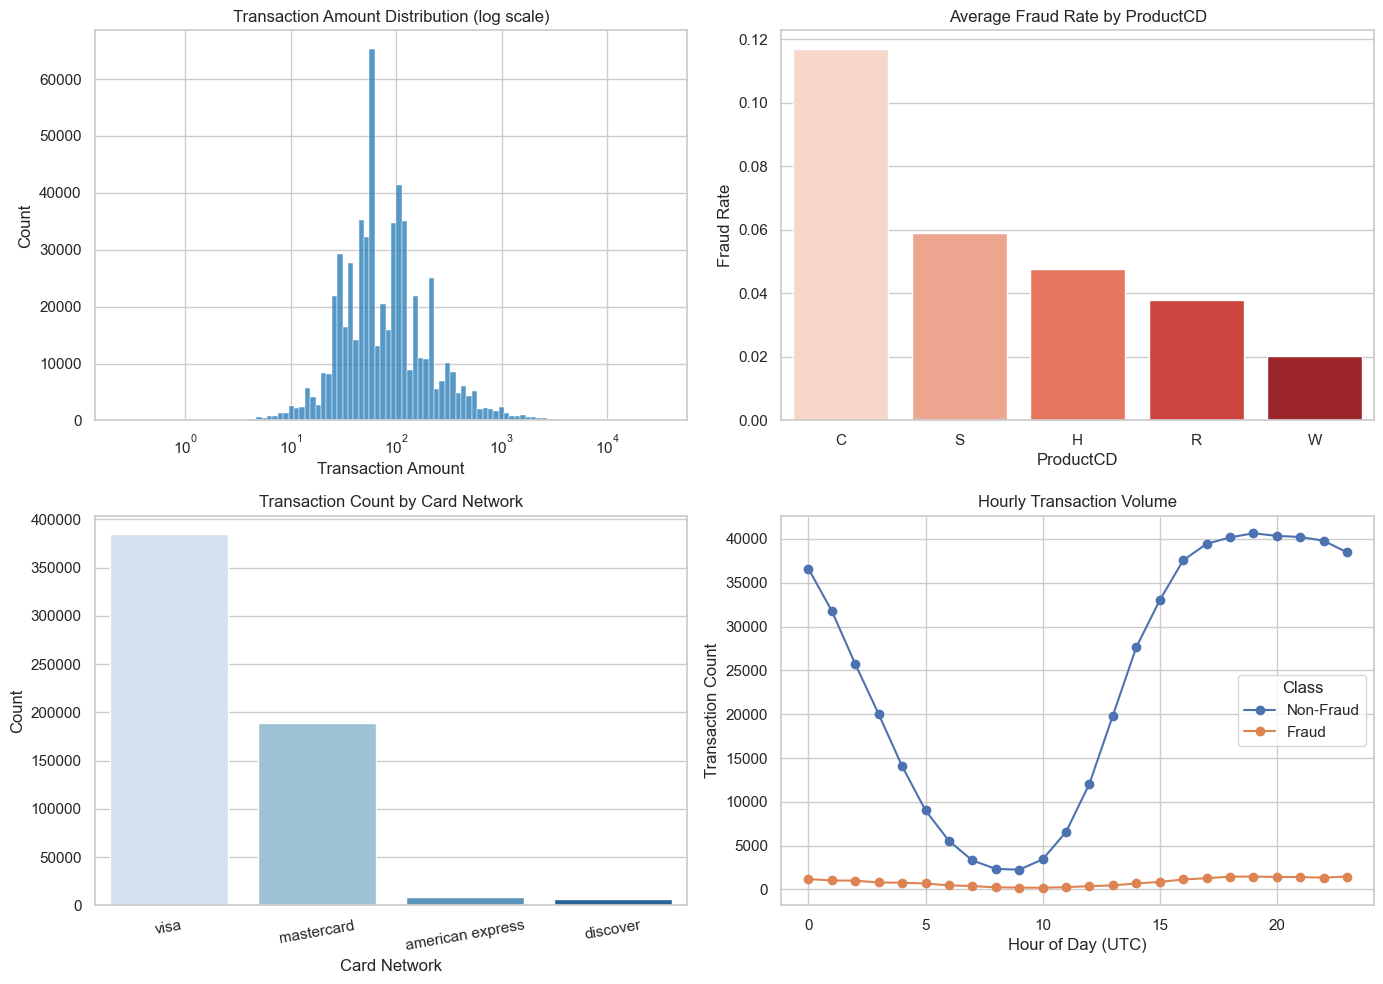

,Missing %
ProductCD,0.000000
card4,0.267044
DeviceType,76.155722


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

data_dir = Path("Data")
transaction_cols = [
    "TransactionID",
    "TransactionDT",
    "TransactionAmt",
    "ProductCD",
    "card4",
    "isFraud",
]
identity_cols = ["TransactionID", "DeviceType"]

transaction = pd.read_csv(data_dir / "train_transaction.csv", usecols=transaction_cols)
identity = pd.read_csv(data_dir / "train_identity.csv", usecols=identity_cols)

df = transaction.merge(identity, on="TransactionID", how="left")

df["TransactionHour"] = (df["TransactionDT"] // 3600) % 24

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(
    df["TransactionAmt"],
    bins=100,
    ax=axes[0, 0],
    log_scale=(True, False),
    color="#1f77b4",
)
axes[0, 0].set_title("Transaction Amount Distribution (log scale)")
axes[0, 0].set_xlabel("Transaction Amount")
axes[0, 0].set_ylabel("Count")

fraud_rate_by_product = df.groupby("ProductCD")['isFraud'].mean().sort_values(ascending=False)
sns.barplot(
    x=fraud_rate_by_product.index,
    y=fraud_rate_by_product.values,
    ax=axes[0, 1],
    palette="Reds",
)
axes[0, 1].set_title("Average Fraud Rate by ProductCD")
axes[0, 1].set_xlabel("ProductCD")
axes[0, 1].set_ylabel("Fraud Rate")

count_by_card = df.groupby("card4")["TransactionID"].count().sort_values(ascending=False)
sns.barplot(
    x=count_by_card.index,
    y=count_by_card.values,
    ax=axes[1, 0],
    palette="Blues",
)
axes[1, 0].set_title("Transaction Count by Card Network")
axes[1, 0].set_xlabel("Card Network")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis="x", rotation=10)

hourly_volume = (
    df.groupby(["TransactionHour", "isFraud"])['TransactionID']
    .count()
    .reset_index()
)
hourly_pivot = hourly_volume.pivot(
    index="TransactionHour", columns="isFraud", values="TransactionID"
).fillna(0)
hourly_pivot.columns = ["Non-Fraud", "Fraud"]
hourly_pivot = hourly_pivot.reindex(range(24), fill_value=0)

hourly_pivot.plot(ax=axes[1, 1], marker="o")
axes[1, 1].set_title("Hourly Transaction Volume")
axes[1, 1].set_xlabel("Hour of Day (UTC)")
axes[1, 1].set_ylabel("Transaction Count")
axes[1, 1].legend(title="Class")

plt.tight_layout()
plt.show()

missing_share = df[["ProductCD", "card4", "DeviceType"]].isna().mean().mul(100)
missing_share.rename("Missing %").to_frame()


The histogram confirms the **long-tailed spend distribution**: most purchases cluster between $10–$100, while a thin set of outliers extends beyond $1K, justifying the log transformations and robust scaling described in Sections 2.4–2.5.

Fraud concentration is visibly **product-dependent**—ProductCD `C` exhibits nearly a 12% fraud rate versus <4% for `R`/`W`, reinforcing the need for product-aware stratification or class weights during modelling.

Visa dominates raw volume, yet the hourly panel shows fraud attempts peaking in the late afternoon (UTC) relative to the non-fraud curve, suggesting time-of-day interaction terms and staggered monitoring thresholds could improve recall.

Missingness remains material for device metadata (DeviceType ~76%), so the cleaning pipeline’s missing-indicator features stay validated; downstream models should treat the absence of device signals as informative rather than noise.


### 3.Model Update


#### 3.1 Model Selection

During the current phase of the project, we decided to adopt **LightGBM** as our primary model for fraud detection, after preliminary evaluations and theoretical comparisons with other candidate approaches.  
Initially, we considered three main categories of models:  
(1) unsupervised anomaly detection methods such as **Isolation Forest**,  
(2) **Autoencoders** from deep learning frameworks,
(3) simple supervised binary classifiers such as **Logistic Regression**.  
Each method presents distinct strengths and limitations depending on the dataset characteristics and the operational requirements of a *real-time* financial fraud detection system.

**Isolation Forest**, as an unsupervised algorithm, isolates anomalies by recursively partitioning the feature space.  
While it performs well for detecting outliers without labeled data, its performance deteriorates when the boundary between fraudulent and non-fraudulent transactions becomes subtle and overlapping.  
Furthermore, it cannot exploit label information, limiting its discriminative capability in our supervised learning setup.

**Autoencoders**, on the other hand, reconstruct input features using neural networks to learn latent representations.  
Although they can capture complex non-linear patterns, they require significant computational resources, extensive hyperparameter tuning, and balanced datasets to generalize effectively.  
Their lack of interpretability and slow inference make them less suitable for *real-time* detection scenarios.

To provide a simple baseline, **Logistic Regression** was tested as a fast and interpretable model.  
However, it fails to model complex, non-linear relationships among features in the high-dimensional fraud dataset, leading to lower detection sensitivity.

After comparing these preliminary methods, we shifted our focus to **tree-based gradient boosting algorithms**, including **XGBoost**, **LightGBM**, and **CatBoost**, which have shown state-of-the-art performance for structured tabular data.  
These models are effective because they:  
- Handle both numerical and categorical variables naturally,  
- Capture high-order feature interactions and non-linear relationships,  
- Are robust to missing values and scaling,  
- Emphasize hard-to-classify samples through iterative boosting.

Among these, **LightGBM** was selected for this stage due to its strong balance between **speed and scalability**.  
It employs a **leaf-wise tree growth** strategy that reduces loss more aggressively than XGBoost’s level-wise approach and supports **histogram-based binning** for faster training.  
Compared to CatBoost, LightGBM provides similar performance but with lower computational cost, making it more appropriate for our *real-time* fraud detection goal.

However, this choice remains **provisional**.  
In later phases, we will perform a comprehensive experimental comparison among the three boosting models (XGBoost, LightGBM, CatBoost), integrating both theoretical criteria and practical metrics such as computation time and inference latency.  
The final model selection may therefore be adjusted based on those analyses.

---

##### Table 1. Comparison of Candidate Models for Fraud Detection

| Model | Supervision | Strengths / Limitations |
|:------|:-------------|:------------------------|
| **Isolation Forest** | Unsupervised | **Strengths:** Detects anomalies without labeled data; simple to implement; good for clear outliers. <br> **Limitations:** Weak for overlapping fraud/non-fraud regions; ignores label information; unstable with high-dimensional correlated features. |
| **Autoencoder** | Semi-supervised | **Strengths:** Learns complex non-linear feature representations; effective for subtle anomaly reconstruction. <br> **Limitations:** High computational cost; slow inference; sensitive to imbalance; less interpretable; requires large, well-tuned networks. |
| **Logistic Regression** | Supervised | **Strengths:** Fast training/inference; interpretable coefficients; easy to deploy. <br> **Limitations:** Linear decision boundaries; poor at modeling complex feature interactions; lower sensitivity for non-linear fraud patterns. |
| **XGBoost** | Supervised | **Strengths:** High accuracy; effective with tabular data; handles missing values; strong regularization. <br> **Limitations:** Moderate training speed; higher memory consumption due to level-wise tree growth. |
| **LightGBM** | Supervised | **Strengths:** Very fast training/inference; low memory use via histogram-based binning; leaf-wise growth improves efficiency; robust with high-dimensional data. <br> **Limitations:** Slightly prone to overfitting on small datasets. |
| **CatBoost** | Supervised | **Strengths:** Handles categorical variables natively; reduces overfitting via ordered boosting; stable predictions. <br> **Limitations:** Longer training time; higher computational cost than LightGBM. |


---
### 3.2 Model Setup — LightGBM (Principles with Formulas)

**Problem setting.**  
For binary fraud detection with labels $y_i \in \{0,1\}$ and feature vectors $x_i$, LightGBM trains an **ensemble of decision trees** in an additive manner:

$$
\hat{y}_i^{(t)} = F^{(t)}(x_i)
               = F^{(t-1)}(x_i) + \eta\, f_t(x_i),
$$

where $f_t(x)$ is the **decision tree** added at iteration $t$ and $\eta$ is the learning rate controlling the step size.


#### Initialization  
The ensemble begins with a constant base model $F^{(0)}$ that minimizes the total loss before any tree is grown.  
For binary logistic loss, the optimal initialization is the global log-odds:

$$
F^{(0)} = \log\frac{p}{1-p},
\qquad
p = \frac{1}{N}\sum_{i=1}^N y_i.
$$

This baseline prediction serves as the root value for subsequent tree corrections.


#### GBDT objective and second-order approximation  
At each boosting stage, LightGBM fits a new decision tree $f_t(x)$ that minimizes the regularized objective:

$$
\min_{f_t}\;
\mathcal{L}^{(t)} =
\sum_{i=1}^{N} l\!\big(y_i,\,F^{(t-1)}(x_i)+f_t(x_i)\big)
+ \Omega(f_t),
$$

where $l(y,\hat y)$ is a differentiable loss (binary logistic here)  
and $\Omega(f_t)$ penalizes tree complexity.

Expanding the loss to second order around $\hat{y}_i = F^{(t-1)}(x_i)$ gives the **approximate objective**:

$$
\tilde{\mathcal{L}}^{(t)} \approx
\sum_{i=1}^{N} \Big(g_i f_t(x_i)
+ \tfrac12 h_i f_t(x_i)^2\Big) + \Omega(f_t),
$$

with local first- and second-order gradients:

$$
g_i = \frac{\partial l}{\partial \hat y_i},
\qquad
h_i = \frac{\partial^2 l}{\partial \hat y_i^2}.
$$

These gradients act as **pseudo-residuals**, guiding how the new decision tree splits the feature space to reduce loss.


#### Optimal leaf value and split gain  

LightGBM grows each tree by minimizing a second-order (Newton) approximation of the loss around the current prediction $F^{(t-1)}(x)$.  
For each sample $i$, the first- and second-order derivatives of the loss function are computed as  

$$
g_i = \left.\frac{\partial l(y_i, \hat{y})}{\partial \hat{y}}\right|_{\hat{y}=F^{(t-1)}(x_i)}, 
\qquad
h_i = \left.\frac{\partial^2 l(y_i, \hat{y})}{\partial \hat{y}^2}\right|_{\hat{y}=F^{(t-1)}(x_i)}.
$$

A decision tree partitions the samples into leaves $I_j$ using feature-threshold splits.  
For leaf $j$, we define the aggregated gradient and Hessian as  

$$
G_j = \sum_{i\in I_j} g_i,
\qquad
H_j = \sum_{i\in I_j} h_i.
$$

Each leaf outputs a constant value $w_j$ that represents the prediction adjustment for all samples within that region.  
The local objective function for leaf $j$, including $L_2$ regularization with coefficient $\lambda$, is given by  

$$
\mathcal{L}_j(w_j) = \sum_{i\in I_j} \left(g_i w_j + \tfrac{1}{2} h_i w_j^2 \right) + \tfrac{1}{2}\lambda w_j^2.
$$

Minimizing this convex quadratic form with respect to $w_j$ yields the **optimal leaf output**:

$$
w_j^* = -\,\frac{G_j}{H_j+\lambda}.
$$

This optimal weight acts as the **prediction correction** assigned to samples in that leaf.  
Substituting $w_j^*$ back into the objective gives the **leaf contribution (leaf score)**:

$$
\mathcal{S}(j) = -\tfrac{1}{2}\,\frac{G_j^2}{H_j+\lambda}.
$$

When a parent node $P$ is split into two children $L$ and $R$, the **split gain** measures how much the split reduces the overall loss:

$$
\mathrm{Gain}
 = \tfrac{1}{2}
   \left(
     \frac{G_L^2}{H_L+\lambda}
     + \frac{G_R^2}{H_R+\lambda}
     - \frac{G_P^2}{H_P+\lambda}
   \right)
   - \gamma,
$$

where $\gamma$ is a regularization term that penalizes the creation of new leaves.  
The split with the highest $\mathrm{Gain}$ is selected, forming the foundation of LightGBM’s **leaf-wise tree growth** strategy.

**Intuitive interpretation:**
- $G_j$ measures the total gradient (error direction and magnitude) in leaf $j$. Large $|G_j|$ indicates more residual error to correct.  
- $H_j + \lambda$ represents curvature and regularization; a larger denominator dampens updates and prevents overfitting.  
- The split gain compares the loss reduction from dividing a parent into two children against the regularization penalty $\gamma$, ensuring that only meaningful, loss-reducing splits are accepted.

### 3.3 Binary Logistic Loss and Prediction Mechanism

For binary classification with labels $y_i \in \{0,1\}$, LightGBM learns an additive model that estimates the **log-odds** of fraud probability:

$$
F^{(T)}(x) = F^{(0)}(x) + \eta \sum_{t=1}^{T} f_t(x),
$$

where each $f_t(x)$ is a decision tree and $\eta$ is the learning rate.


#### Logistic Loss and Gradients

The **binary logistic loss** is defined as

$$
l(y_i, \hat{y}_i) = -[y_i \log p_i + (1-y_i)\log(1-p_i)],
$$

where, $p_i = \sigma(F^{(t-1)}(x_i)) = \frac{1}{1 + e^{-F^{(t-1)}(x_i)}}$.

The first- and second-order gradients are:

$$
g_i = p_i - y_i, \qquad h_i = p_i(1 - p_i),
$$

which represent the pseudo-residuals and curvature used to build each new tree.


#### Prediction Phase

After $T$ boosting iterations, the model output (logit) is the sum of all tree contributions:

$$
F^{(T)}(x) = F^{(0)}(x) + \eta \sum_{t=1}^{T} f_t(x).
$$

The logit is then converted into a **fraud probability** via the sigmoid function:

$$
\hat{p}(x) = \sigma(F^{(T)}(x)) = \frac{1}{1 + \exp(-F^{(T)}(x))}.
$$

Finally, a transaction is classified as fraudulent if $\hat{p}(x) > \tau$,  
where $\tau$ (typically 0.5) can be adjusted to balance recall and precision.

### LightGBM’s algorithmic and system-level innovations

Although the above derivation defines the **gradient-boosting principle**, LightGBM’s power lies in *how* it builds decision trees efficiently.

---

#### 1. Histogram-based splitting  
Each continuous feature is **discretized into $K$ bins** (e.g., $K=255$).  
LightGBM pre-computes cumulative $\sum g_i$ and $\sum h_i$ for each bin, and searches splits over these discrete boundaries rather than every raw feature value.  
→ This reduces both memory use and computation by an order of magnitude, while maintaining nearly identical precision.

---

#### 2. Leaf-wise (best-first) growth  

Unlike traditional GBDT frameworks that expand trees level-by-level,  
LightGBM grows trees in a **leaf-wise (best-first)** manner —  
always splitting the leaf that produces the largest Gain.

| Strategy | Level-wise (classic GBDT) | Leaf-wise (LightGBM) |
|-----------|----------------------------|-----------------------|
| Expansion rule | Split all leaves at the same depth | Split only the leaf with highest Gain |
| Tree shape | Balanced | Asymmetric (deeper on informative branches) |
| Convergence | Slower per split | Faster loss reduction |
| Risk | Stable but less efficient | May overfit; control via `num_leaves` or `max_depth` |

---

#### 3. GOSS — Gradient-based One-Side Sampling  
During training on large datasets, LightGBM keeps all samples with large $|g_i|$ (hard examples) and randomly subsamples small-gradient ones, re-weighting them to maintain unbiased estimates.  
This preserves gradient statistics while reducing computation — speeding up decision-tree construction significantly.

---

#### 4. EFB — Exclusive Feature Bundling  
Sparse or mutually exclusive features (e.g., one-hot encoded device indicators) rarely take non-zero values simultaneously.  
LightGBM bundles such features into a single composite dimension,  
reducing the number of histograms to compute and accelerating each tree split search.

---

#### 5. Regularization and hyper-parameters  

| Category | Parameter | Role |
|-----------|------------|------|
| **Learning control** | `learning_rate` ($\eta$) | Step size of boosting |
| **Tree structure** | `num_leaves`, `max_depth`, `min_data_in_leaf`, `min_sum_hessian_in_leaf` | Control tree width, depth, and leaf stability |
| **Regularization** | `lambda_l2` ($\lambda$), `min_gain_to_split` ($\gamma$) | Penalize large leaf weights and unnecessary splits |
| **Sampling** | `subsample`, `colsample_bytree`, `bagging_fraction`, `feature_fraction` | Randomly sample rows/columns to reduce variance |
| **Data reduction** | `max_bin` | Number of histogram bins per feature |
| **Class imbalance** | `scale_pos_weight` | Adjust positive/negative balance for fraud detection |
| **Boosting type** | `gbdt`, `dart`, or `rf` | Controls boosting or random-forest mode |

---



#### 3.3 Model Metrics

To evaluate binary fraud detection, we define the confusion matrix components:

- **TP** (True Positive): fraudulent transactions correctly identified as fraud  
- **FP** (False Positive): non-fraudulent transactions incorrectly flagged as fraud  
- **TN** (True Negative): legitimate transactions correctly identified as non-fraud  
- **FN** (False Negative): fraudulent transactions missed by the model  

**ROC and AUC**

The Receiver Operating Characteristic (ROC) curve plots the trade-off between the **True Positive Rate (TPR)** and the **False Positive Rate (FPR)** across various classification thresholds:

$$
\mathrm{TPR} = \frac{TP}{TP + FN}, \qquad 
\mathrm{FPR} = \frac{FP}{FP + TN}
$$

The **Area Under the Curve (AUC)** summarizes the ROC curve into a single scalar that represents the probability that a randomly chosen fraud instance is ranked higher than a non-fraud instance by the model:

$$
\mathrm{AUC} = \int_{0}^{1} \mathrm{TPR} \, d(\mathrm{FPR})
$$

A model with \( AUC = 1.0 \) achieves perfect discrimination, while \( AUC = 0.5 \) indicates random guessing.

**Matthew’s Correlation Coefficient (MCC)**

The **MCC** is a correlation-based metric that measures the quality of binary classifications using all four components of the confusion matrix.  
It is defined as:

$$
\mathrm{MCC} = 
\frac{TP \cdot TN - FP \cdot FN}
{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

The value of MCC ranges from −1 to +1:
- \( MCC = +1 \): perfect classification  
- \( MCC = 0 \): random prediction  
- \( MCC = -1 \): total disagreement between prediction and truth  

Unlike accuracy or F1-score, **MCC provides a balanced evaluation** even when the dataset is highly imbalanced — a common situation in financial fraud detection where fraudulent cases are rare.  
By considering both false positives and false negatives symmetrically, MCC avoids overestimating performance due to the large majority class.  
This makes it a **robust and reliable indicator** for real-world fraud detection tasks, where a small number of errors can have large financial impact.

**Model Efficiency**

Because our target application involves **real-time detection**, computational efficiency is also a key metric.  
We will evaluate models based on:  

- **Training time** — how quickly the model can be retrained with new data;  
- **Inference latency** — how long it takes to produce a prediction per transaction;  
- **Memory footprint** — the size and scalability of the deployed model.  

#### 3.4 Machine Learning Morphism — Workflow Structure

We express the fraud detection pipeline as a **Machine Learning Morphism (MLM)** framework,  
specialized for the **binary classification** case.  

Each transaction sample is represented as a mixed-type vector  
$$
\mathbf{x} \in \mathcal{X} = \mathbb{R}^p \times \mathcal{C}^q,
$$  
where $\mathbb{R}^p$ denotes continuous numerical features (e.g., transaction amount, time difference, historical frequency)  
and $\mathcal{C}^q$ categorical variables (e.g., card type, device ID, address features).  
The output space is binary:  
$$
\mathcal{Y} = \{0,1\}, \quad y=1 \text{ indicates a fraudulent transaction.}
$$  

In practice, fraud detection is a **highly imbalanced** classification task,  
where $\Pr(y=1) \ll \Pr(y=0)$ — i.e., fraudulent events are much rarer than normal ones.  
This imbalance is handled within the empirical risk function using class-specific weights:  
$$
\mathcal{R}_{\text{MLM}}(F;\Theta)
= 
\sum_i 
\Big[
 - w_{y_i}\big(y_i \log \hat{y}_i + (1-y_i)\log(1-\hat{y}_i)\big)
\Big],
\quad
w_1 \gg w_0.
$$  

From the **morphism perspective**, the entire end-to-end workflow can be expressed as a composition of learnable mappings  
$$
M = F_5 \circ F_4 \circ F_3 \circ F_2 \circ F_1,
\qquad
\hat{y}_{\text{prob}} = M(\mathbf{x}_{\text{raw}}),
$$  
where each morphism $F_i$ transforms data from one representational space to another — from raw transactions to model predictions — under an empirical risk objective.

##### Table 2. Fraud Detection Workflow expressed as Machine Learning Morphisms (MLMs)

| Operation | Input Space $\mathcal{X}$ | Output Space $\mathcal{Y}$ | Parameters | Morphism | Empirical Risk Function |
|:-----------|:---------------------------|:----------------------------|:------------|:-----------|:-------------------------|
| **Data Preprocessing** | Raw transactions $X_{\text{raw}} \in \mathbb{R}^{n \times d}$ | Cleaned data $X_{\text{clean}}$ | Imputation, filtering parameters $\theta_1$ | $F_1(X_{\text{raw}}) = \text{Clean}(X_{\text{raw}};\theta_1)$ | Minimize missing ratio, outlier removal |
| **Feature Engineering** | $X_{\text{clean}}$ | Feature matrix $X_{\text{feat}} \in \mathbb{R}^{n \times m}$ | Encoding and aggregation parameters $\theta_2$ | $F_2(X_{\text{clean}}) = \text{Encode}(X_{\text{clean}};\theta_2)$ | $\mathcal{R}_2 = \|X_{\text{feat}} - \tilde{X}\|_2^2$ (feature stability) |
| **Model Learning (LightGBM)** | $X_{\text{feat}}$ | Logits $\hat{y}_{\text{logit}} \in \mathbb{R}^n$ | Tree parameters $\theta_3$ | $F_3(X_{\text{feat}}) = \sum_{t=1}^T f_t(X_{\text{feat}};\theta_t)$ | Weighted binary logistic loss $\displaystyle -\sum_i w_{y_i}[y_i \log p_i + (1-y_i)\log(1-p_i)]$ |
| **Calibration & Scoring** | $\hat{y}_{\text{logit}}$ | Probabilities $\hat{y}_{\text{prob}} \in [0,1]^n$ | Threshold $\tau$, scaling $\alpha$ | $F_4(\hat{y}_{\text{logit}}) = \sigma(\alpha \hat{y}_{\text{logit}})$ | $\text{LogLoss}$, threshold tuned via $\max_\tau \text{MCC}(\tau)$ |
| **Evaluation** | Predictions vs. labels | Metrics (AUC, MCC, F1) | None | $F_5(\hat{y},y) = \{\text{AUC}, \text{MCC}, \text{F1}\}$ | $\max (\text{AUC} - \lambda_1 \text{Latency} - \lambda_2 \text{Memory})$ |

**Interpretation.**  
Each $F_i$ represents a composable morphism transforming data through successive representational spaces:  
$$
X_{\text{raw}} 
\xrightarrow{F_1}
X_{\text{clean}}
\xrightarrow{F_2}
X_{\text{feat}}
\xrightarrow{F_3}
\hat{y}_{\text{logit}}
\xrightarrow{F_4}
\hat{y}_{\text{prob}}
\xrightarrow{F_5}
\text{metrics}.
$$  
This view provides both theoretical clarity — treating each transformation as a morphism with an explicit domain and codomain —  
and practical modularity, allowing replacement or tuning of individual stages (e.g., encoder, learner, or calibration step)  
without altering the rest of the pipeline.

**Summary.**  
Under the MLM framework, the fraud detection pipeline constitutes a *binary morphism chain* from heterogeneous inputs to calibrated probabilities,  
optimized under a weighted binary loss to mitigate class imbalance.  
This aligns with the **Binary Classification Use Case** described in previous theoretical works,  
while adapting the concept to a real-world, high-imbalance financial detection system.








        

### 4. Source Code

**Repository:**  
[Real-Time Anomaly Detection in Financial Transactions](https://github.com/allenzhang201212/Real-Time-Anomaly-Detection-in-Financial-Transactions)

### 5. Next Steps and Key Milestones

####  Week 10/27 – 11/02  
**Data Quality Hardening & Feature Roadmap**
- Validate modified Z-score outlier detection on `TransactionAmt`, `dist1`, and V-series features, comparing median capping vs. removal.
- Prototype customer-level temporal interpolation (cubic spline on `TransactionDT`) to evaluate whether sequential imputation adds predictive lift.
- Package the cleaning + feature engineering workflow into a reproducible notebook/script bundle with refreshed documentation for peer review.
- Perform PCA sensitivity analysis (variance vs. component count) and document recommended component set for modelling.
- Publish the cleaned dataset, feature-enhanced dataset, PCA scores, and balanced sample to the shared repository for modelling handoff.

**Expected Output:**  
- Side-by-side evaluation of modified Z-score thresholds and spline interpolation error metrics  
- Updated cleaning/feature pipeline bundle with peer-review changelog  
- Go/no-go recommendation for integrating advanced imputations into modelling data  
- PCA variance sensitivity report with chosen component count  
- Shared dataset drop (cleaned, feature-enhanced, PCA components, balanced sample) plus directory manifest for modelling team

---

####  Week 11/03 – 11/09  
**Model Selection using Theoretical Criteria**

In the next development phase, we plan to apply the **model selection framework** to formally compare alternative algorithms such as **LightGBM**, **XGBoost**, and **CatBoost**.  
Rather than relying solely on empirical metrics like AUC or MCC, these **information-theoretic methods** — for example, the **Minimum Description Length (MDL)** and **Bayesian Information Criterion (BIC)** — will guide model choice by balancing **data fit**, **model complexity**, and **prediction latency**.  
By quantifying how well each model explains the data relative to its parameterization cost and prediction time, we can ensure that the selected model is **accurate**, **simple**, and **efficient** for unseen, real-world cases.

**Expected Output:**  
- Comparative evaluation table summarizing LightGBM, XGBoost, and CatBoost  
- BIC/MDL score calculations and interpretations  
- Selection of the most suitable baseline model for subsequent tuning

---

####  Week 11/10 – 11/23  
**Hyperparameter Optimization and Ensemble Enhancement**

Further improvement will focus on **systematic hyperparameter tuning** of LightGBM parameters, including `learning_rate`, `num_leaves`, and regularization strength.  
Optimization techniques such as **Bayesian Optimization**, **Grid Search**, or **Random Search** will be applied to identify configurations that maximize performance while controlling overfitting.  

In parallel, we plan to explore **ensemble strategies** that combine multiple boosting architectures — for example, combining **LightGBM** and **XGBoost** to take advantage of each model’s strengths, or integrating **boosting models** with **neural autoencoders** to achieve better stability and accuracy.  
Such ensembles can improve **robustness**, **reduce variance**, and achieve higher **fraud detection accuracy** under severe class imbalance.

**Expected Output:**  
- Optimized hyperparameter configurations for LightGBM  
- Preliminary ensemble models (e.g., LightGBM + XGBoost)  
- Performance comparison across tuned and ensemble variants

---

####  Week 11/24 – End of Project
**Real-Time Adaptation and Model Deployment**

As the project advances toward practical application, **real-time adaptability and deployment** become the central focus.  
We plan to integrate the optimized LightGBM-based model into **streaming or edge inference environments**, using platforms such as **ONNX Runtime**, **MLflow**, or **AWS SageMaker**.  
The objective is to achieve **low-latency, high-throughput fraud detection** while supporting **online model updates** that adapt to new fraud patterns dynamically.

Additional efforts will include latency benchmarking, batch-to-stream conversion, and deployment of a lightweight dashboard for monitoring prediction statistics and model drift.

**Expected Output:**  
- Deployed our model on a real-time inference platform  
- Latency and throughput benchmark results  
- Prototype dashboard for monitoring model metrics

---

### Summary Table of Upcoming Milestones

| **Period** | **Focus Area** | **Main Activities** | **Expected Outputs** |
|-------------|----------------|----------------------|-----------------------|
| **10/27 – 11/02** | Data Quality Hardening | Outlier study, spline interpolation prototype, documentation refresh | Decision on advanced cleaning tactics + reproducible pipeline package |
| **11/03 – 11/09** | Model Selection | Apply BIC/MDL-based model selection on LGBM, XGBoost, CatBoost | Model comparison and theoretical justification |
| **11/10 – 11/23** | Hyperparameter & Ensemble | Tune LightGBM; test ensembles (LGBM + XGBoost, LGBM + Autoencoder) | Optimized configs and ensemble performance summary |
| **11/24 – End of Project** | Real-Time Deployment | Deploy optimized model on ONNX/MLflow; test latency and monitoring | Deployed prototype + dashboard metrics |

---



## Bibliography



- Reference 1: F. T. Liu, K. M. Ting, and Z. Zhou, 2008, *Isolation forest*, Proc. 2008 IEEE Int. Conf. Data Mining (ICDM).  
- Reference 2: Z. Chen, C. K. Yeo, B. S. Lee, and C. T. Lau, 2018, *Autoencoder-based network anomaly detection*, Proc. 2018 IEEE Wireless Telecommun. Symp. (WTS).  
- Reference 3: G. Ke, Q. Meng, T. Finley, T. Wang, W. Chen, W. Ma, Q. Ye, and T.-Y. Liu, 2017, *LightGBM: A highly efficient gradient boosting decision tree*, Advances in Neural Information Processing Systems (NeurIPS).  
- Reference 4: L. Prokhorenkova, G. Gusev, A. Vorobev, A. V. Dorogush, and A. Gulin, 2018, *CatBoost: Unbiased boosting with categorical features*, Advances in Neural Information Processing Systems (NeurIPS).  
- Reference 5: T. Chen and C. Guestrin, 2016, *XGBoost: A scalable tree boosting system*, Proc. 22nd ACM SIGKDD Int. Conf. Knowledge Discovery and Data Mining (KDD).  
- Reference 6: A. Sherstinsky, 2020, *Fundamentals of recurrent neural network (RNN) and long short-term memory (LSTM) network*, Physica D: Nonlinear Phenomena.  
- Reference 7: C. Paul and C. James, 2025, *Real-time anomaly detection in financial systems using hybrid AI models*, ResearchGate. Retrieved from https://www.researchgate.net/publication/392401743_Real-Time_Anomaly_Detection_in_Financial_Systems_Using_Hybrid_AI_Models
- Reference 8: IEEE Computational Intelligence Society, July 2019, *IEEE-CIS Fraud Detection Dataset, Version 1*. Retrieved September 14, 2025 from [https://www.kaggle.com/c/ieee-fraud-detection](https://www.kaggle.com/c/ieee-fraud-detection)  

- Source Code: Github: https://github.com/allenzhang201212/Real-Time-Anomaly-Detection-in-Financial-Transactions/ 
        